# 📊 Stage 1: 現状把握分析

## 目的
**「今、お店で何が起きているのか？」を数字で把握する**

このノートブックでは、以下の基本的な経営指標を分析します：

### 分析内容
1. **売上の全体像**
   - 日次・週次・月次の売上推移
   - 店舗別のパフォーマンス比較
   - 前年同期比・前月比の変化

2. **時間帯・曜日パターン**
   - 曜日別の売上傾向（月曜は弱い？土日は強い？）
   - 休日・平日の違い
   - 給料日前後の変化

3. **カテゴリ別の貢献度**
   - どのカテゴリが売上を支えているか
   - カテゴリ別の成長率

### 業務的な意義
- **オーナー・店長**: 店舗の健康状態を把握し、改善の優先順位を決める
- **発注担当**: 曜日・時期による売れ行きの違いを理解する
- **本部報告**: 客観的なデータで店舗状況を説明できる

---

## 📦 1. 環境準備

In [ ]:
# 日本語フォント設定（共通モジュール）
import warnings
warnings.filterwarnings('ignore')

# よく使うライブラリを先に読み込む
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ウィジェットの有無を通知・フラグ化
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    WIDGETS_AVAILABLE = True
    print('✅ ipywidgets利用可能')
except Exception:
    WIDGETS_AVAILABLE = False
    print('⚠️ ipywidgets未インストール - 一部機能制限')

import font_setup
JP_FP = font_setup.setup_fonts(show_test=False)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

## 📁 2. データ読み込み

In [3]:
# データファイルのパス
file_path = 'output/06_final_enriched_20250701_20250930.csv'

print(f"📂 データ読み込み中: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8-sig')

# 日付型に変換
df['日付'] = pd.to_datetime(df['日付'])

print(f"\n✅ 読み込み完了")
print(f"   データ期間: {df['日付'].min().strftime('%Y-%m-%d')} 〜 {df['日付'].max().strftime('%Y-%m-%d')}")
print(f"   データ件数: {len(df):,}行")
print(f"   対象店舗: {df['店舗'].nunique()}店舗")
print(f"   店舗名: {', '.join(df['店舗'].unique())}")

📂 データ読み込み中: output/06_final_enriched_20250701_20250930.csv

✅ 読み込み完了
   データ期間: 2025-07-01 〜 2025-09-30
   データ件数: 83,789行
   対象店舗: 3店舗
   店舗名: 58738:ＴＸ秋葉原駅, 69795:ＴＸ六町駅／Ｓ, 77576:ＴＸつくば駅


## 📊 3. 全体サマリー

### 業務的な見方
- **売上金額**: 売上高（レジを通った金額）
- **売上数量**: 販売個数（何個売れたか）
- **客単価**: 1回の買い物でいくら使われたか（売上÷客数）
- **客数**: 何人のお客様が来店したか（推定）

In [4]:
# 全期間の集計
print("="*60)
print("📈 全期間サマリー（3ヶ月間）")
print("="*60)

total_sales = df['売上金額'].sum()
total_quantity = df['売上数量'].sum()
avg_price = total_sales / total_quantity if total_quantity > 0 else 0
days_count = (df['日付'].max() - df['日付'].min()).days + 1

print(f"\n💰 売上金額合計: ¥{total_sales:,.0f}")
print(f"📦 売上数量合計: {total_quantity:,.0f}個")
print(f"💵 平均単価: ¥{avg_price:,.0f}/個")
print(f"📅 営業日数: {days_count}日間")
print(f"📊 1日平均売上: ¥{total_sales/days_count:,.0f}")

print("\n" + "-"*60)
print("【業務的な意味】")
print(f"  ✓ この3ヶ月で約{total_sales/1000000:.1f}百万円を売り上げています")
print(f"  ✓ 1日あたり約{total_sales/days_count/1000:.0f}千円の売上です")
print(f"  ✓ 商品1個あたりの平均価格は{avg_price:.0f}円です")

📈 全期間サマリー（3ヶ月間）

💰 売上金額合計: ¥83,148,413
📦 売上数量合計: 420,251個
💵 平均単価: ¥198/個
📅 営業日数: 92日間
📊 1日平均売上: ¥903,787

------------------------------------------------------------
【業務的な意味】
  ✓ この3ヶ月で約83.1百万円を売り上げています
  ✓ 1日あたり約904千円の売上です
  ✓ 商品1個あたりの平均価格は198円です


## 🏪 4. 店舗別パフォーマンス

### 業務的な見方
各店舗の特性を理解し、優良事例を他店に横展開するヒントを得る

In [5]:
# 店舗別集計
store_summary = df.groupby('店舗').agg({
    '売上金額': 'sum',
    '売上数量': 'sum',
    '日付': 'nunique'
}).round(0)

store_summary.columns = ['売上金額', '売上数量', '営業日数']
store_summary['1日平均売上'] = (store_summary['売上金額'] / store_summary['営業日数']).round(0)
store_summary['平均単価'] = (store_summary['売上金額'] / store_summary['売上数量']).round(0)
store_summary['構成比'] = (store_summary['売上金額'] / store_summary['売上金額'].sum() * 100).round(1)

# ソート（売上金額降順）
store_summary = store_summary.sort_values('売上金額', ascending=False)

print("="*60)
print("🏪 店舗別パフォーマンス")
print("="*60)
print(store_summary.to_string())

print("\n" + "-"*60)
print("【業務的な意味】")
print("  ✓ 構成比: 全体売上に対する各店舗の貢献度")
print("  ✓ 1日平均売上: その店舗の日次売上力")
print("  ✓ 平均単価: 客単価や商品ミックスの指標")

🏪 店舗別パフォーマンス
                        売上金額  売上数量  営業日数  1日平均売上  平均単価  構成比
店舗                                                                               
77576:ＴＸつくば駅    38355741.0  209391.0        92     416910.0     183.0    46.1
58738:ＴＸ秋葉原駅    30227934.0  150904.0        92     328564.0     200.0    36.4
69795:ＴＸ六町駅／Ｓ  14564738.0   59956.0        92     158312.0     243.0    17.5

------------------------------------------------------------
【業務的な意味】
  ✓ 構成比: 全体売上に対する各店舗の貢献度
  ✓ 1日平均売上: その店舗の日次売上力
  ✓ 平均単価: 客単価や商品ミックスの指標


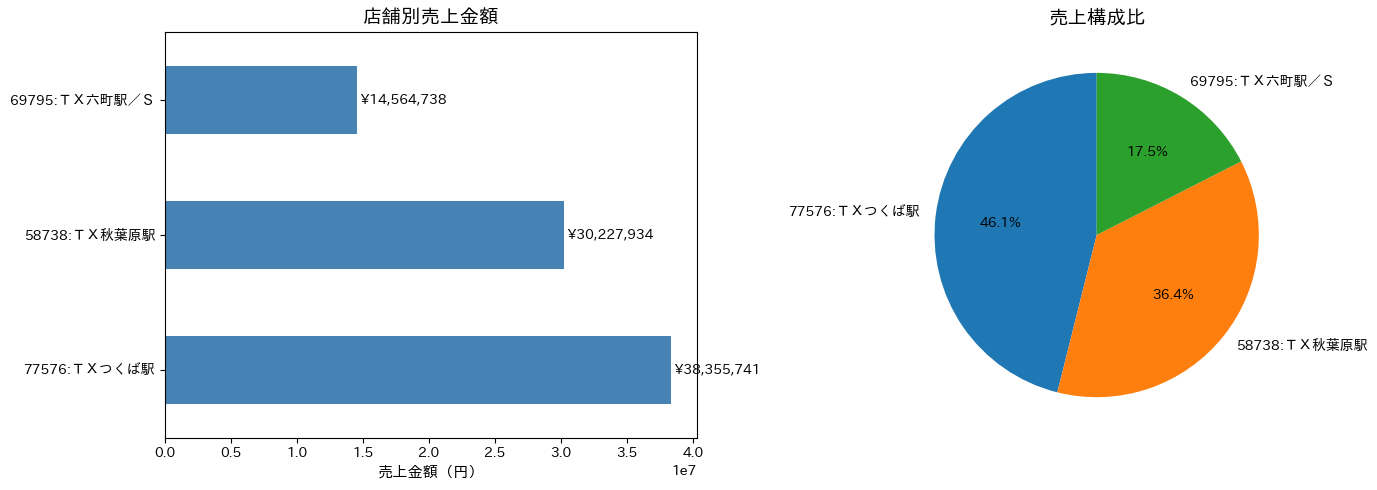


💡 店舗特性の理解
  → 最も売上が高い店舗: 77576:ＴＸつくば駅
  → 最も1日平均が高い店舗: 77576:ＴＸつくば駅


In [6]:
# 店舗別売上のグラフ化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 売上金額
store_summary['売上金額'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('店舗別売上金額', fontsize=14, fontproperties=JP_FP)
axes[0].set_xlabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('', fontproperties=JP_FP)
for i, v in enumerate(store_summary['売上金額']):
    axes[0].text(v, i, f' ¥{v:,.0f}', va='center', fontsize=10, fontproperties=JP_FP)

# 構成比
store_summary['構成比'].plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('売上構成比', fontsize=14, fontproperties=JP_FP)
axes[1].set_ylabel('', fontproperties=JP_FP)

plt.tight_layout()
plt.show()

print("\n💡 店舗特性の理解")
print(f"  → 最も売上が高い店舗: {store_summary.index[0]}")
print(f"  → 最も1日平均が高い店舗: {store_summary.sort_values('1日平均売上', ascending=False).index[0]}")

## 📅 5. 日次・週次・月次トレンド

### 業務的な見方
- **上昇トレンド**: 施策が効いている、季節が良い
- **下降トレンド**: 競合影響、商品構成の見直しが必要
- **変動が大きい**: 天気・イベント依存度が高い

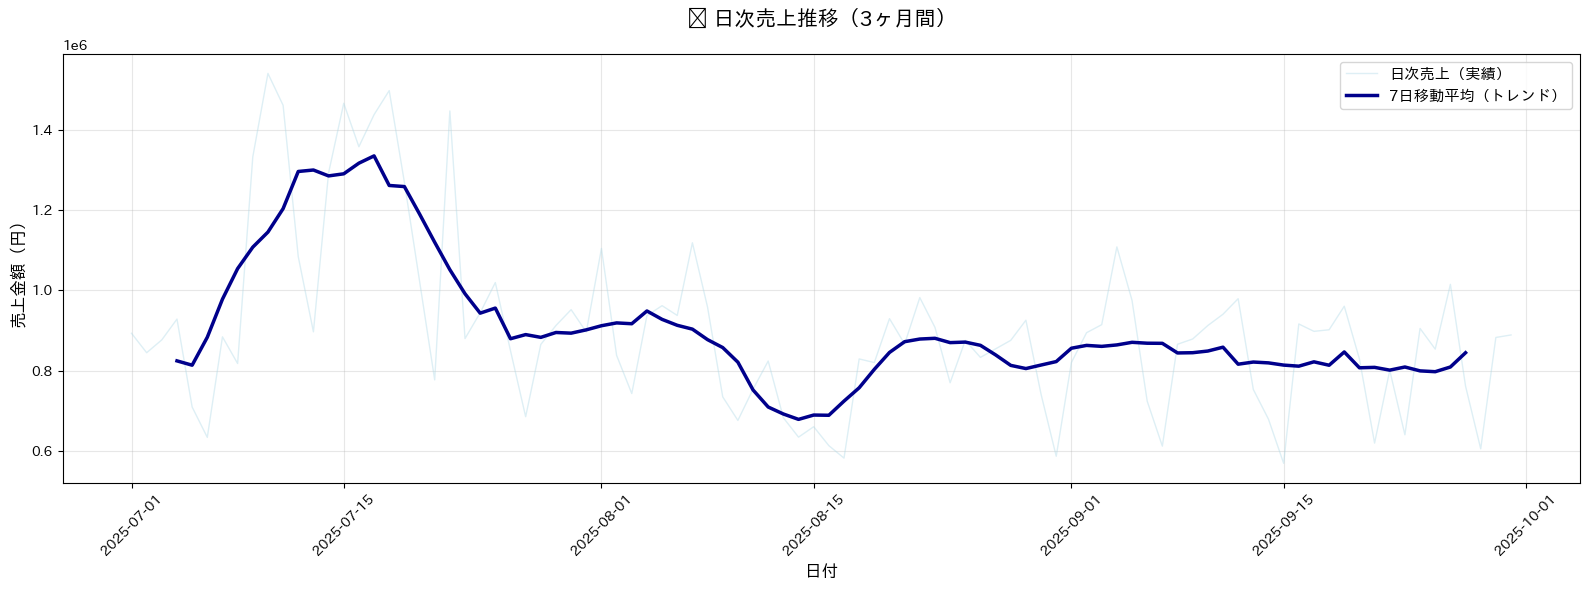


💡 トレンドの読み方
  ✓ 青い太線が右上がり → 売上が伸びている
  ✓ 青い太線が右下がり → 売上が落ちている
  ✓ 細い線の上下幅が大きい → 日による変動が大きい（天気・イベント影響大）


In [7]:
# 日次売上集計
daily_sales = df.groupby('日付').agg({
    '売上金額': 'sum',
    '売上数量': 'sum'
}).reset_index()

# 7日移動平均（トレンドを見やすくする）
daily_sales['売上金額_7日平均'] = daily_sales['売上金額'].rolling(window=7, center=True).mean()

# グラフ化
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(daily_sales['日付'], daily_sales['売上金額'], 
        alpha=0.4, color='lightblue', linewidth=1, label='日次売上（実績）')
ax.plot(daily_sales['日付'], daily_sales['売上金額_7日平均'], 
        color='darkblue', linewidth=2.5, label='7日移動平均（トレンド）')

ax.set_title('📈 日次売上推移（3ヶ月間）', fontsize=15, pad=20, fontproperties=JP_FP)
ax.set_xlabel('日付', fontsize=12, fontproperties=JP_FP)
ax.set_ylabel('売上金額（円）', fontsize=12, fontproperties=JP_FP)
ax.legend(fontsize=11, prop=JP_FP)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 トレンドの読み方")
print("  ✓ 青い太線が右上がり → 売上が伸びている")
print("  ✓ 青い太線が右下がり → 売上が落ちている")
print("  ✓ 細い線の上下幅が大きい → 日による変動が大きい（天気・イベント影響大）")

## 📆 6. 曜日別パターン分析

### 業務的な意義
**発注計画の基本**: 曜日による売れ行きの違いを把握し、適切な発注量を決める

In [8]:
# 曜日マッピング
weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
df['曜日名'] = df['日付'].dt.dayofweek.map(weekday_map)

# 曜日別集計
weekday_sales = df.groupby('曜日名').agg({
    '売上金額': ['sum', 'mean', 'count'],
    '売上数量': 'sum'
}).round(0)

weekday_sales.columns = ['売上金額_合計', '売上金額_平均', 'データ件数', '売上数量_合計']
weekday_order = ['月', '火', '水', '木', '金', '土', '日']
weekday_sales = weekday_sales.reindex(weekday_order)

# 平日を100としたインデックス
weekday_avg = weekday_sales.loc[['月', '火', '水', '木', '金'], '売上金額_平均'].mean()
weekday_sales['指数'] = (weekday_sales['売上金額_平均'] / weekday_avg * 100).round(0)

print("="*60)
print("📆 曜日別売上パターン")
print("="*60)
print(weekday_sales.to_string())

print("\n" + "-"*60)
print("【指数の読み方】")
print("  100 = 平日平均")
print("  120 = 平日より20%多く売れる")
print("   80 = 平日より20%少ない")

📆 曜日別売上パターン
        売上金額_合計  売上金額_平均  データ件数  売上数量_合計   指数
曜日名                                                                
月         11155172.0          997.0       11193        54456.0   96.0
火         13195582.0         1012.0       13039        65932.0   98.0
水         12401971.0         1017.0       12198        61568.0   98.0
木         12995421.0         1067.0       12181        62582.0  103.0
金         13467692.0         1090.0       12361        67060.0  105.0
土         10817127.0          970.0       11146        59291.0   94.0
日          9115448.0          891.0       10225        49362.0   86.0

------------------------------------------------------------
【指数の読み方】
  100 = 平日平均
  120 = 平日より20%多く売れる
   80 = 平日より20%少ない


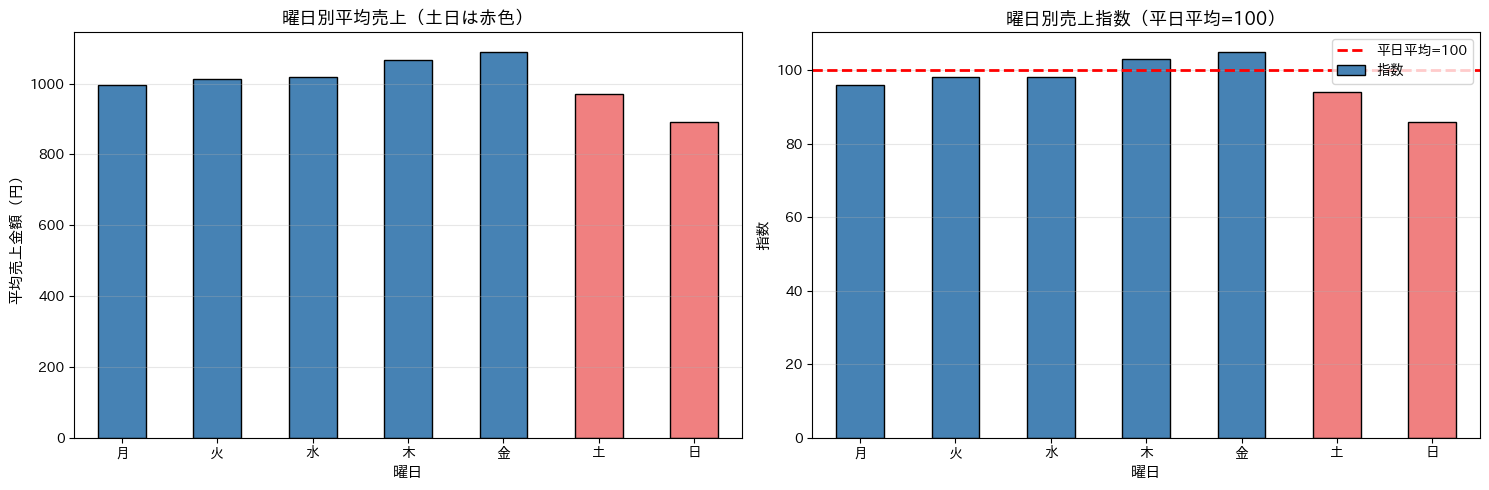


💡 発注への活用
  → 最も売れる曜日: 金曜日
  → 最も売れない曜日: 日曜日
  → 金曜日の発注は平日の1.1倍必要


In [9]:
# グラフ化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 曜日別平均売上
colors = ['lightcoral' if day in ['土', '日'] else 'steelblue' for day in weekday_order]
weekday_sales['売上金額_平均'].plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('曜日別平均売上（土日は赤色）', fontsize=13, fontproperties=JP_FP)
axes[0].set_xlabel('曜日', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('平均売上金額（円）', fontsize=11, fontproperties=JP_FP)
axes[0].set_xticklabels(weekday_order, rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# 指数
weekday_sales['指数'].plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='平日平均=100')
axes[1].set_title('曜日別売上指数（平日平均=100）', fontsize=13, fontproperties=JP_FP)
axes[1].set_xlabel('曜日', fontsize=11, fontproperties=JP_FP)
axes[1].set_ylabel('指数', fontsize=11, fontproperties=JP_FP)
axes[1].set_xticklabels(weekday_order, rotation=0)
axes[1].legend(prop=JP_FP)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 発注への活用")
strongest_day = weekday_sales['売上金額_平均'].idxmax()
weakest_day = weekday_sales['売上金額_平均'].idxmin()
print(f"  → 最も売れる曜日: {strongest_day}曜日")
print(f"  → 最も売れない曜日: {weakest_day}曜日")
print(f"  → {strongest_day}曜日の発注は平日の{weekday_sales.loc[strongest_day, '指数']/100:.1f}倍必要")

## 🎌 7. 休日・平日の比較

### 業務的な意義
休日は客層・購買パターンが変わるため、発注・シフト計画を変える必要がある

🎌 休日・平日の比較
      売上金額_合計  売上金額_平均   日数  売上数量_合計   指数
平日     60474705.0         1046.0  57835       298164.0  100.0
休日     22673708.0          925.0  24508       122087.0   88.0


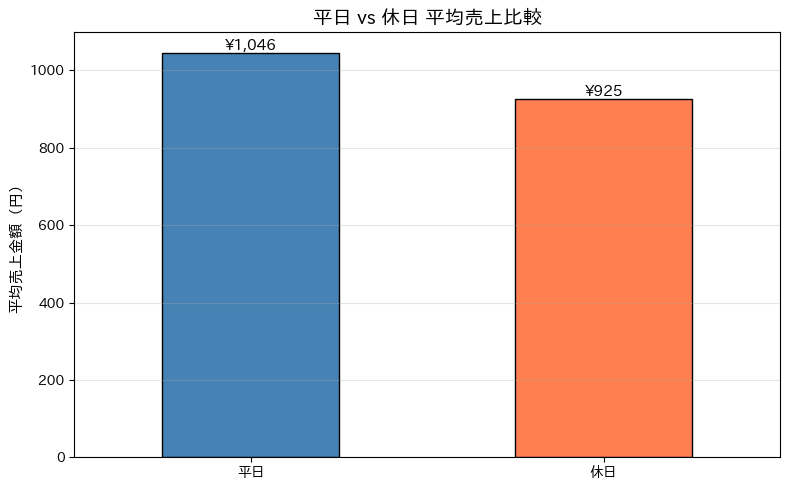


💡 業務への示唆
  → 休日は平日より-11.6%売上が変動
  → 休日の発注・シフトは平日の0.88倍で済む


In [10]:
# 休日フラグがあるか確認
if '休日フラグ' in df.columns:
    holiday_comparison = df.groupby('休日フラグ').agg({
        '売上金額': ['sum', 'mean', 'count'],
        '売上数量': 'sum'
    }).round(0)
    
    holiday_comparison.columns = ['売上金額_合計', '売上金額_平均', '日数', '売上数量_合計']
    holiday_comparison.index = ['平日', '休日']
    
    # 平日を100としたインデックス
    holiday_comparison['指数'] = (holiday_comparison['売上金額_平均'] / 
                                   holiday_comparison.loc['平日', '売上金額_平均'] * 100).round(0)
    
    print("="*60)
    print("🎌 休日・平日の比較")
    print("="*60)
    print(holiday_comparison.to_string())
    
    # グラフ化
    fig, ax = plt.subplots(figsize=(8, 5))
    holiday_comparison['売上金額_平均'].plot(kind='bar', ax=ax, color=['steelblue', 'coral'], edgecolor='black')
    ax.set_title('平日 vs 休日 平均売上比較', fontsize=14, fontproperties=JP_FP)
    ax.set_xlabel('', fontsize=11, fontproperties=JP_FP)
    ax.set_ylabel('平均売上金額（円）', fontsize=11, fontproperties=JP_FP)
    ax.set_xticklabels(['平日', '休日'], rotation=0)
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(holiday_comparison['売上金額_平均']):
        ax.text(i, v, f'¥{v:,.0f}', ha='center', va='bottom', fontsize=11, fontproperties=JP_FP)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 業務への示唆")
    diff_pct = (holiday_comparison.loc['休日', '売上金額_平均'] / 
                holiday_comparison.loc['平日', '売上金額_平均'] - 1) * 100
    print(f"  → 休日は平日より{diff_pct:+.1f}%売上が変動")
    if diff_pct > 0:
        print(f"  → 休日の発注・シフトは平日の{1 + diff_pct/100:.2f}倍必要")
    else:
        print(f"  → 休日の発注・シフトは平日の{1 + diff_pct/100:.2f}倍で済む")
else:
    print("⚠️ '休日フラグ' 列が見つかりません")

## 📦 8. カテゴリ別売上構成

### 業務的な意義
どのカテゴリが売上を支えているか理解し、売場・在庫配分を最適化する

In [11]:
# 大分類別集計
category_sales = df.groupby('フェイスくくり大分類').agg({
    '売上金額': 'sum',
    '売上数量': 'sum'
}).sort_values('売上金額', ascending=False)

category_sales['構成比'] = (category_sales['売上金額'] / category_sales['売上金額'].sum() * 100).round(1)
category_sales['累積構成比'] = category_sales['構成比'].cumsum().round(1)
category_sales['平均単価'] = (category_sales['売上金額'] / category_sales['売上数量']).round(0)

print("="*60)
print("📦 カテゴリ別売上（大分類）")
print("="*60)
print(category_sales.to_string())

print("\n" + "-"*60)
print("【累積構成比の見方】")
print("  ✓ 80%を占めるカテゴリ → 重点管理が必要")
print("  ✓ 残り20%のカテゴリ → 効率的な運用を考える")

📦 カテゴリ別売上（大分類）
                              売上金額  売上数量  構成比  累積構成比  平均単価
フェイスくくり大分類                                                          
290:たばこ                  17548793.0   34601.0    21.1        21.1     507.0
100:米飯                    15378721.0   79765.0    18.5        39.6     193.0
215:ドライ飲料              14804873.0  112038.0    17.8        57.4     132.0
145:パン                     7513568.0   51756.0     9.0        66.4     145.0
110:調理パン                 4363530.0   13656.0     5.2        71.6     320.0
180:ガム・キャンディ         4246163.0   24873.0     5.1        76.7     171.0
135:牛乳・チルド飲料         2113940.0   12854.0     2.5        79.2     164.0
280:チケット・カード         2113310.0     189.0     2.5        81.7   11182.0
205:健康サポート飲料         1699667.0    8454.0     2.0        83.7     201.0
240:紙・衛生用品             1353080.0    4891.0     1.6        85.3     277.0
185:洋風菓子・駄菓子         1328408.0    8155.0     1.6        86.9     163.0
305:ワイン・洋酒             1259495.0    7142.0     1.5

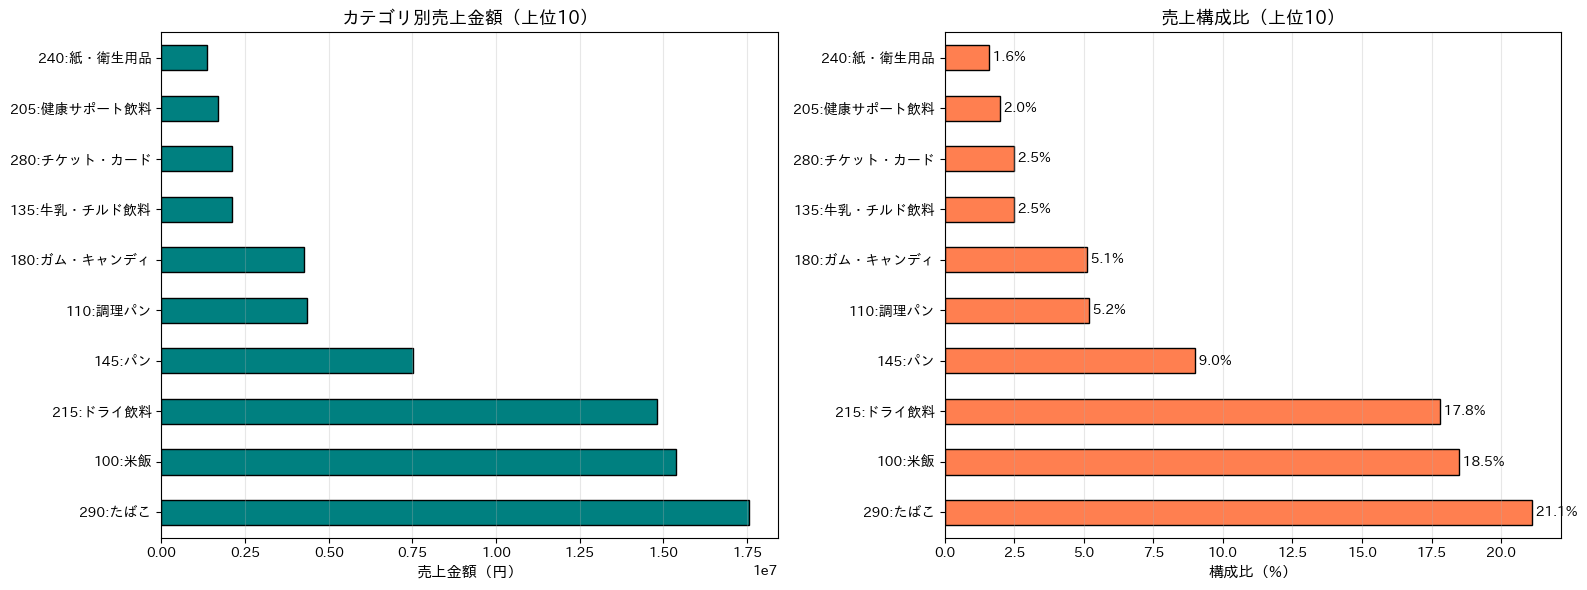


💡 カテゴリ戦略
  → 上位3カテゴリで全体の57.4%を占める
  → 重点カテゴリ: 290:たばこ, 100:米飯, 215:ドライ飲料


In [12]:
# カテゴリ別グラフ（上位10カテゴリ）
top10_categories = category_sales.head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 売上金額
top10_categories['売上金額'].plot(kind='barh', ax=axes[0], color='teal', edgecolor='black')
axes[0].set_title('カテゴリ別売上金額（上位10）', fontsize=13, fontproperties=JP_FP)
axes[0].set_xlabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('', fontproperties=JP_FP)
axes[0].grid(axis='x', alpha=0.3)

# 構成比
top10_categories['構成比'].plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('売上構成比（上位10）', fontsize=13, fontproperties=JP_FP)
axes[1].set_xlabel('構成比（%）', fontsize=11, fontproperties=JP_FP)
axes[1].set_ylabel('', fontproperties=JP_FP)
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(top10_categories['構成比']):
    axes[1].text(v, i, f' {v}%', va='center', fontsize=10, fontproperties=JP_FP)

plt.tight_layout()
plt.show()

print("\n💡 カテゴリ戦略")
top3 = category_sales.head(3)
print(f"  → 上位3カテゴリで全体の{top3['構成比'].sum():.1f}%を占める")
print(f"  → 重点カテゴリ: {', '.join(top3.index.tolist())}")

## 📊 9. 月次推移（前月比）

### 業務的な意義
月ごとの成長・減少を把握し、季節変動や施策効果を評価する

📊 月次売上推移
           売上金額  売上数量  営業日数  1日平均売上  前月比
年月                                                        
2025-07  32477768.0  168206.0        31    1047670.0     NaN
2025-08  25560921.0  128002.0        31     824546.0   -21.3
2025-09  25109724.0  124043.0        30     836991.0    -1.8


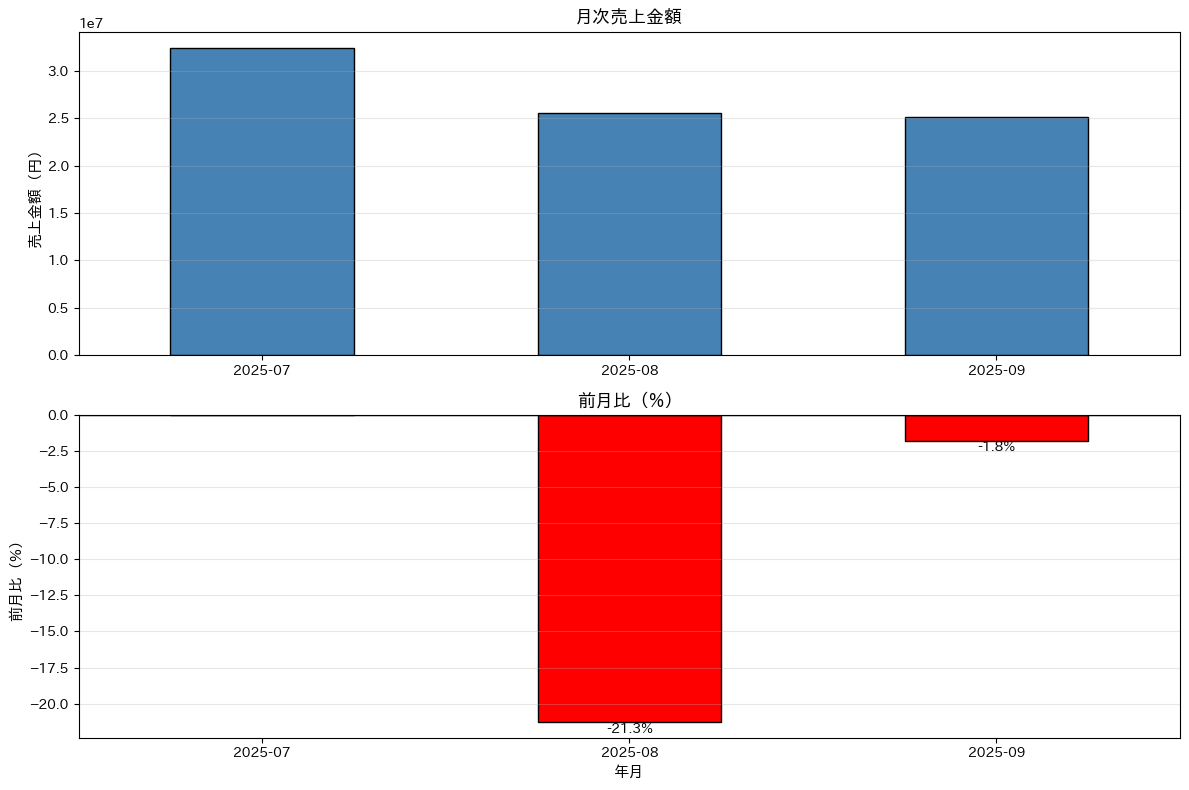


💡 月次トレンド
  → 2025-09は前月比-1.8%と減少 → 要因分析が必要


In [13]:
# 月次集計
df['年月'] = df['日付'].dt.to_period('M').astype(str)
monthly_sales = df.groupby('年月').agg({
    '売上金額': 'sum',
    '売上数量': 'sum',
    '日付': 'nunique'
}).round(0)

monthly_sales.columns = ['売上金額', '売上数量', '営業日数']
monthly_sales['1日平均売上'] = (monthly_sales['売上金額'] / monthly_sales['営業日数']).round(0)
monthly_sales['前月比'] = (monthly_sales['売上金額'].pct_change() * 100).round(1)

print("="*60)
print("📊 月次売上推移")
print("="*60)
print(monthly_sales.to_string())

# グラフ化
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 売上金額
monthly_sales['売上金額'].plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('月次売上金額', fontsize=13, fontproperties=JP_FP)
axes[0].set_ylabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
axes[0].set_xlabel('', fontproperties=JP_FP)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(monthly_sales.index, rotation=0)

# 前月比
colors = ['green' if x > 0 else 'red' for x in monthly_sales['前月比'].fillna(0)]
monthly_sales['前月比'].plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('前月比（%）', fontsize=13, fontproperties=JP_FP)
axes[1].set_ylabel('前月比（%）', fontsize=11, fontproperties=JP_FP)
axes[1].set_xlabel('年月', fontsize=11, fontproperties=JP_FP)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(monthly_sales.index, rotation=0)

for i, v in enumerate(monthly_sales['前月比'].fillna(0)):
    if v != 0:
        axes[1].text(i, v, f'{v:+.1f}%', ha='center', va='bottom' if v > 0 else 'top', fontsize=10, fontproperties=JP_FP)

plt.tight_layout()
plt.show()

print("\n💡 月次トレンド")
if len(monthly_sales) >= 2:
    latest_month = monthly_sales.index[-1]
    latest_change = monthly_sales['前月比'].iloc[-1]
    if pd.notna(latest_change):
        if latest_change > 0:
            print(f"  → {latest_month}は前月比{latest_change:+.1f}%と好調")
        else:
            print(f"  → {latest_month}は前月比{latest_change:.1f}%と減少 → 要因分析が必要")

## 💡 10. Stage 1 まとめ

### 次のステップ
このStage 1で「現状」を把握しました。

**次に進むべきは:**
- **Stage 2**: どの商品が重要か（ABC分析）
- **Stage 3**: いつ、どれだけ発注すべきか（需要予測）
- **Stage 4**: 天気・イベントの影響を理解する
- **Stage 5**: PyCaretで機械学習モデルを構築する

---

### 保存推奨
このノートブックの実行結果を保存しておくと、週次・月次での定点観測ができます。

In [14]:
# 主要指標をCSV保存（週次レポート用）
output_dir = Path('output/stage1_reports')
output_dir.mkdir(parents=True, exist_ok=True)

# 保存する集計データ
store_summary.to_csv(output_dir / 'store_summary.csv', encoding='utf-8-sig')
weekday_sales.to_csv(output_dir / 'weekday_sales.csv', encoding='utf-8-sig')
category_sales.to_csv(output_dir / 'category_sales.csv', encoding='utf-8-sig')
monthly_sales.to_csv(output_dir / 'monthly_sales.csv', encoding='utf-8-sig')

print("✅ レポートデータを保存しました:")
print(f"   {output_dir}/")
print("\n次回以降、このデータと比較することで変化を追跡できます。")

✅ レポートデータを保存しました:
   output/stage1_reports/

次回以降、このデータと比較することで変化を追跡できます。
